In [1]:
import os
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'

/tf/notebooks/schnemau/xAI_stroke_3d


In [2]:
# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
#from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
#from keras.utils import to_categorical
#from classification_models_3D.tfkeras import Classifiers
import os
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
#from keras import backend as K
#from classification_models_3D.tfkeras import Classifiers
from tensorflow.keras.optimizers import Adam

2.4.0


Using TensorFlow backend.


In [3]:
# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters
from functions.augmentation3d import zoom, rotate, flip, shift

In [4]:
model = tf.keras.models.load_model("/tf/notebooks/schnemau/xAI_stroke_3d/model/test2.h5", custom_objects={'loss': ontram_loss})

### read-in Data

In [5]:

# should only non TIA (transient ischemic attack) patients be included?
only_non_tia = False

with h5py.File(path_img, "r") as h5:
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

X_in = np.expand_dims(X_in, axis = 4)

print("image shape in: ", X_in.shape)
print("image min, max, mean, std: ", X_in.min(), X_in.max(), X_in.mean(), X_in.std())


## read tabular data
dat = pd.read_csv(path_tab, sep=",")
# get original data

n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], 3)) #hardcoding for resnet50
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
p_id = p_id.astype("int")

X[:,:,:,:,1] = X[:,:,:,:,0] #hardcoding for resnet50 adjustment (grayscale vs. colour)
X[:,:,:,:,2] = X[:,:,:,:,0]
        


image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


In [6]:
## all mrs <= 2 are favorable all higher unfavorable
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

In [7]:
# split train validation test
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(range(X.shape[0]), train_size = int(X.shape[0]*0.8), random_state = 20)
train_idx, valid_idx = train_test_split(range(len(train_idx)), train_size = int(len(train_idx)*0.8), random_state = 20)

X_train = X[train_idx]
X_valid = X[valid_idx]
X_test = X[test_idx]

X_tab_train = X_tab[train_idx]
X_tab_valid = X_tab[valid_idx]
X_tab_test = X_tab[test_idx]

Y_img_train = Y_img[train_idx]
Y_img_valid = Y_img[valid_idx]
Y_img_test = Y_img[test_idx]

#Y_pat_train = Y_pat[train_idx]
#Y_pat_valid = Y_pat[valid_idx]
#Y_pat_test = Y_pat[test_idx]

pat_train = p_id[train_idx]
pat_valid = p_id[valid_idx]
pat_test = p_id[test_idx]

Y_mrs_train = Y_mrs[train_idx]
Y_mrs_valid = Y_mrs[valid_idx]
Y_mrs_test = Y_mrs[test_idx]

#print(X_train.shape, X_tab_train.shape, Y_img_train.shape, Y_pat_train.shape, pat_train.shape, Y_mrs_train.shape)
#print(X_valid.shape, X_tab_valid.shape, Y_img_valid.shape, Y_pat_valid.shape, pat_valid.shape, Y_mrs_valid.shape)
#print(X_test.shape, X_tab_test.shape, Y_img_test.shape, Y_pat_test.shape, pat_test.shape, Y_mrs_test.shape)

print(X_train.shape, X_tab_train.shape, Y_img_train.shape, pat_train.shape, Y_mrs_train.shape)
print(X_valid.shape, X_tab_valid.shape, Y_img_valid.shape, pat_valid.shape, Y_mrs_valid.shape)
print(X_test.shape, X_tab_test.shape, Y_img_test.shape, pat_test.shape, Y_mrs_test.shape)


(260, 128, 128, 28, 3) (260, 13) (260, 28) (260,) (260,)
(65, 128, 128, 28, 3) (65, 13) (65, 28) (65,) (65,)
(82, 128, 128, 28, 3) (82, 13) (82, 28) (82,) (82,)


In [8]:
# to categorical (only for the patient label stroke vs. no stroke)
#Y_pat_train = to_categorical(Y_pat_train)
#Y_pat_valid = to_categorical(Y_pat_valid)
#Y_pat_test = to_categorical(Y_pat_test)

Y_mrs_train = to_categorical(Y_mrs_train)
Y_mrs_valid = to_categorical(Y_mrs_valid)
Y_mrs_test = to_categorical(Y_mrs_test)

### Jonas Occlusion Code

In [9]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl

In [10]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,3)

In [11]:
volume = volume.reshape(input_shape)

In [12]:
heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

In [13]:
## Generate all possible occlusions
X_occ = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
            X_occ.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 3)) #3 changed from 1 manually
            xyz.append((x,y,z))

In [14]:
def iterate_hm_generation(X_occ, X_patient, Y_patient, model):
    X_occ_2 = np.array(X_occ)
    data_loader_1 = np.ones(shape=[len(X_occ_2),1])
    data_loader_2 = X_occ_2
    data_loader_3 = np.repeat((X_patient,), repeats=len(X_occ_2), axis=0)
    data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1,data_loader_2,data_loader_3))
    data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_patient,), repeats=len(X_occ_2), axis=0))
    occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
    data_occ_full = occ_loader.batch(5, drop_remainder = True)
    preds_occ = predict_ontram(model, data = data_occ_full)
    #TODO: count per iteration...
    return preds_occ


pred_res_occ =  {"cdf": [], "pdf" : np.zeros(shape=(len(X_occ), 3)), "pred_class": [], "nll": []} #empty dict

for i in range(int(len(X_occ)/100)):
    iter_res = iterate_hm_generation(X_occ[(i*100):(i*100)+100], X_tab[0], Y_mrs_test[0], model)    
    
    for j in range(len(iter_res['pdf'])):
        pred_res_occ['pdf'][(i*100)+j] = iter_res['pdf'][j]


In [15]:
for i in range(len(X_occ)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += pred_res_occ['pdf'][i][0]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


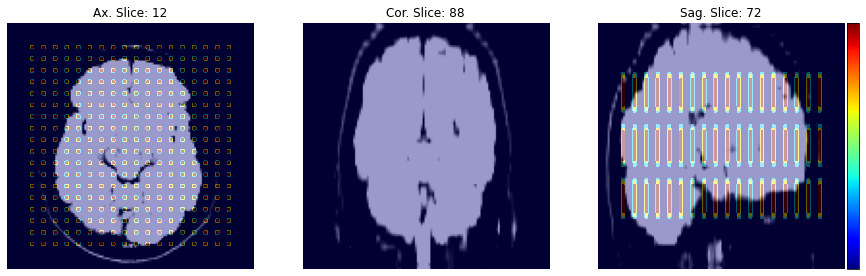

In [16]:
phm.plot_heatmap(X[0], hm,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)